In [1]:
import numpy as np
np.set_printoptions(threshold=10000,suppress=True)
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import torch

## Traitement des données de base

In [41]:
def traitementCSVTemperature(fichier):
    data = pd.read_csv(fichier,sep=';', header=0)
    data = data[['numer_sta','date','t']]
    data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H%M%S', utc=True)
    data['heure'] = data['date'].dt.hour
    data['date'] = data['date'].dt.date
    #On enlève les stations qui n'ont pas un ID entre 7000 et 8000 (outre-mer)
    data = data[data['numer_sta'] >= 7000]
    data = data[data['numer_sta'] <= 8000]
    data = data[data['t'] != 'mq']
    data['t'] = data['t'].astype(float)
    data['t'] = data['t'] - 273.15
    data = data.groupby(['date','heure','numer_sta']).mean()
    data = data.groupby(['date','heure']).mean()
    data.reset_index(inplace=True)
    return data

In [42]:
def traitementCSVConsomation(fichier):
    rte = pd.read_csv(fichier,sep=';', header=0)
    rte['Date'] = pd.to_datetime(rte['Date'], dayfirst=True)
    rte['Date'] = rte['Date'].dt.date
    rte = rte[rte['Heures'].str.endswith('00')]
    rte['Heures'] = rte['Heures'].str.slice(0,2)
    rte['Heures'] = rte['Heures'].astype(int)
    return rte

In [43]:
def fusionData(rte,temperature):
    data = pd.merge(rte,temperature,how='inner',left_on=['Date','Heures'],right_on=['date','heure'])
    data = data.drop(['date','heure'],axis=1)
    data = data.dropna()
    return data

In [44]:
def traitementAllCSVTemperatures(fichiers):
    data = pd.DataFrame()
    for fichier in fichiers:
        temp = traitementCSVTemperature(fichier)
        data = pd.concat([data,temp])
    data = data.groupby(['date','heure']).mean()
    data.reset_index(inplace=True)
    return data

In [45]:
fichiers_temperature = []
for annee in [2015, 2016, 2017, 2018, 2019]:
    for mois in range(1,13):
        if mois < 10:
            fichiers_temperature.append('temperatures/synop.'+str(annee)+'0'+str(mois)+'.csv')
        else:
            fichiers_temperature.append('temperatures/synop.'+str(annee)+str(mois)+'.csv')
temperatures = traitementAllCSVTemperatures(fichiers_temperature)

In [46]:
rte  = pd.DataFrame()
for annee in [2015, 2016, 2017, 2018, 2019]:
    rte = pd.concat([rte, traitementCSVConsomation('rte_'+str(annee)+'.csv')])

In [47]:
data_total = fusionData(rte,temperatures)

In [48]:
data_total.to_csv('data_total.csv',index=False, sep=';')

## Traitement des données pour apprentissage

In [82]:
def ajouterJourSemaine(data):
    data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
    data['jour_semaine'] = data['Date'].dt.dayofweek
    data['jour_mois'] = data['Date'].dt.day
    data['mois'] = data['Date'].dt.month
    return data

def enleverDate(data):
    data = data.drop(['Date'],axis=1)
    return data


def swap_consommation(df):
    col_list = list(df.columns)
    x, y = col_list.index('Consommation'), col_list.index(df.columns[len(df.columns)-1])
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

def ajoutJourFerie(df):
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df['jour_ferie'] = df['Date'].isin(pd.to_datetime(['2015-01-01','2015-04-03','2015-05-01','2015-05-08','2015-05-21','2015-05-25','2015-06-01','2015-07-14','2015-08-15','2015-11-01','2015-11-11','2015-12-25','2016-01-01','2016-03-25','2016-05-01','2016-05-05','2016-05-08','2016-05-16','2016-05-25','2016-06-01','2016-07-14','2016-08-15','2016-11-01','2016-11-11','2016-12-25','2017-01-01','2017-04-14','2017-05-01','2017-05-08','2017-05-25','2017-05-29','2017-06-01','2017-07-14','2017-08-15','2017-11-01','2017-11-11','2017-12-25','2018-01-01','2018-03-30','2018-05-01','2018-05-08','2018-05-10','2018-05-21','2018-05-25','2018-06-01','2018-07-14','2018-08-15','2018-11-01','2018-11-11','2018-12-25','2019-01-01','2019-04-19','2019-05-01','2019-05-08','2019-05-30','2019-05-31','2019-06-01','2019-07-14','2019-08-15','2019-11-01','2019-11-11','2019-12-25']))
    df['jour_ferie'] = df['jour_ferie'].astype(int)
    return df


#On met la colonne 'Consommation' en dernière position

data_apprentissage = ajouterJourSemaine(data_total)
data_apprentissage = ajoutJourFerie(data_apprentissage)
data_apprentissage = enleverDate(data_apprentissage)
data_apprentissage = swap_consommation(data_apprentissage)

data_apprentissage.to_csv('data_apprentissage_2018.csv',index=False, sep=';')
data_apprentissage.head(3)

,Heures,jour_ferie,t,jour_semaine,jour_mois,mois,Consommation
0,0,1,-0.483333,3,1,1,74494.0
1,3,1,-1.133333,3,1,1,68840.0
2,6,1,-1.378571,3,1,1,64210.0


In [83]:
from sklearn.model_selection import train_test_split
x = data_apprentissage.iloc[:, :-1].values
y = data_apprentissage.iloc[:, -1].values
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

In [84]:

from sklearn.utils import shuffle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DataLoader(object):
    def __init__(self, x, y, batch_size=128, shuffle=True):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.start_idx = 0
        self.data_size = x.shape[0]
        if self.shuffle:
            self.reset()

    def reset(self):
        self.x, self.y = shuffle(self.x, self.y, random_state=1)

    def __iter__(self):
        return self

    def __next__(self):
        if self.start_idx >= self.data_size:
            if self.shuffle:
                self.reset()
            self.start_idx = 0
            raise StopIteration

        batch_x = self.x[self.start_idx:self.start_idx+self.batch_size]
        batch_y = self.y[self.start_idx:self.start_idx+self.batch_size]

        batch_x = torch.tensor(batch_x, dtype=torch.float, device=device)
        batch_y = torch.tensor(batch_y, dtype=torch.float, device=device)

        self.start_idx += self.batch_size

        return batch_x, batch_y

class MLP(torch.nn.Module):
    def __init__(self, in_dim, caches, out_dim=1):
        super(MLP, self).__init__()

        assert out_dim==1, 'out_dim must be 1'
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.couches = torch.nn.ModuleList()
        for i in range(len(caches)):
            self.couches.append(torch.nn.Linear(self.in_dim if i == 0 else caches[i-1], caches[i]))
        self.couches.append(torch.nn.Linear(caches[-1], self.out_dim))

    def forward(self, x):
        for i in range(len(self.couches)):
            x = torch.relu(self.couches[i](x))
        x=torch.squeeze(x)
        return x

def mae_loss(y_pred, y_true):
    mae = torch.abs(y_true - y_pred).mean()
    return mae


def coef_determ(y_true, y_pred):
    u = ((y_true - y_pred) ** 2).sum()
    v = ((y_true - y_true.mean()) ** 2).sum()
    return 1 - (u / v)


def score_perceptron(x_test: np.array, y_test: np.array, model: MLP):
    y_pred = model(torch.tensor(x_test, dtype=torch.float, device=device))
    y_pred = y_pred.data.cpu().numpy()
    return coef_determ(y_test, y_pred)

In [85]:
train_dataloader = DataLoader(x_train, y_train, batch_size=4000)
valid_dataloader = DataLoader(x_test, y_test, batch_size=4000)

In [53]:
def fit(epochs=200, learning_rate=0.1, couche=None, show_loss=True, train_data:DataLoader=None, valid_data:DataLoader=None):
    assert train_data is not None, 'Les données d\'entrainement sont nulles'
    assert valid_data is not None, 'Les données de validation sont nulles'
    mlp = MLP(x_train[0].shape[0], couche, 1)
    mlp.to(device)
    optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)
    best_loss = np.inf
    valid_losses = []
    for epoch in range(epochs):
        mlp.train()
        for batch_id, (batch_x, batch_y) in enumerate(train_data):
            y_pred = mlp(batch_x)
            loss = mae_loss(y_pred, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        mlp.eval()
        valid_loss = 0
        num_batch = valid_data.data_size // valid_data.batch_size + 1

        for batch_id, (batch_x, batch_y) in enumerate(valid_data):

            y_pred = mlp(batch_x)
            loss = mae_loss(y_pred, batch_y)
            valid_loss += loss.item()

        valid_loss /= num_batch
        valid_losses.append(valid_loss)

        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(mlp.state_dict(), 'mlp.model')
    if show_loss:
        print("Best Loss is " + str(best_loss))
        plt.plot(valid_losses)
        plt.show()
    return mlp, best_loss

In [54]:
def testParameters(couches, lr, nbTest=5, epochs=200, train_data=None, valid_data=None):
    assert train_data is not None, 'Les données d\'entrainement sont nulles'
    assert valid_data is not None, 'Les données de validation sont nulles'
    best = 0
    best_parameters = None
    for couche in couches:
        for learning_rate in lr:
            tot_loss = 0
            for numero_test in range(nbTest):
                mlp, best_loss = fit(couche=couche, learning_rate=learning_rate, show_loss=False, epochs=epochs, train_data=train_data, valid_data=valid_data)
                score = score_perceptron(x_test, y_test,mlp)
                print(f'Couche : {couche}, alpha : {learning_rate}, numéro {numero_test} : {score}')
                tot_loss += score
            tot_loss /= nbTest
            if tot_loss > best:
                best = tot_loss
                best_parameters = [couche, learning_rate]
    return best_parameters, best


In [37]:
best_parameters, best = testParameters([[100,100,100]], [0.01, 0.001, 0.1, 1.0], epochs=1000)

Couche : [100, 100, 100], alpha : 0.01, numéro 0 : -20.488668565267243
Couche : [100, 100, 100], alpha : 0.01, numéro 1 : -20.488668565267243
Couche : [100, 100, 100], alpha : 0.01, numéro 2 : 0.9139294687294697
Couche : [100, 100, 100], alpha : 0.01, numéro 3 : 0.9235447370158374
Couche : [100, 100, 100], alpha : 0.01, numéro 4 : 0.9247028879815345
Couche : [100, 100, 100], alpha : 0.001, numéro 0 : 0.8631657603936796
Couche : [100, 100, 100], alpha : 0.001, numéro 1 : 0.8625539005826873
Couche : [100, 100, 100], alpha : 0.001, numéro 2 : 0.8837428459543887
Couche : [100, 100, 100], alpha : 0.001, numéro 3 : 0.8739751098049908
Couche : [100, 100, 100], alpha : 0.001, numéro 4 : 0.8339213051412366
Couche : [100, 100, 100], alpha : 0.1, numéro 0 : 0.9220870537135869
Couche : [100, 100, 100], alpha : 0.1, numéro 1 : 0.9460905044881907
Couche : [100, 100, 100], alpha : 0.1, numéro 2 : 0.9523363266987307
Couche : [100, 100, 100], alpha : 0.1, numéro 3 : 0.9468077546011856
Couche : [100, 10

In [28]:
best

0

In [16]:
def predict(model, heure, temperature, jour_semaine, jour_mois, mois):
    toPredict = np.array([[heure, mois, temperature, jour_semaine, jour_mois]])
    toPredict = torch.tensor(toPredict,dtype=torch.float,device=device)
    y_pred = model(toPredict)
    y_pred = y_pred.data.cpu().numpy()
    return y_pred

Best Loss is 1498.1805419921875


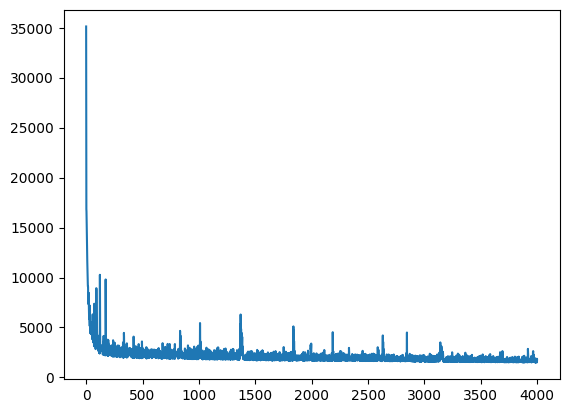

0.9628544133981237

In [86]:
best_model, score = fit(4000, 0.1, [100, 100, 100], True, train_data=train_dataloader, valid_data=valid_dataloader)
score_perceptron(x_test, y_test,best_model)

In [18]:
from datetime import datetime


def testDate(date_str: str, model: MLP):
    date=datetime.strptime(date_str, '%d/%m/%y')
    jour_semaine=date.weekday()
    jour_mois=date.day
    mois=date.month
    data_test = ajouterJourSemaine(data_total)
    data_test = swap_consommation(data_test)
    data_test=data_test[data_test['Date']==date_str]
    data_test = enleverDate(data_test)
    data_predict = []
    data_test.reset_index(inplace=True)
    for i,ligne in data_test.iterrows():
        data_predict.append(predict(model, ligne['Heures'], ligne['t'], jour_semaine, jour_mois, mois))
    plt.plot(data_test['Consommation'])
    plt.plot(data_predict)
    plt.legend(['Consommation réelle', 'Consommation estimée'])
    plt.show()

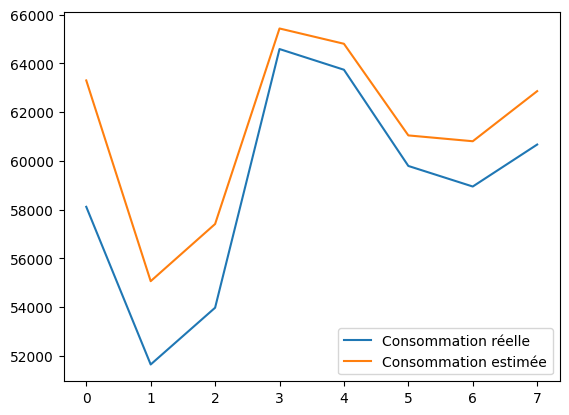

In [49]:
testDate('28/02/19', best_model)

In [51]:
score_perceptron(x_test, y_test, best_model)

0.9598768523014791

In [57]:
torch.save(best_model, 'model_non_normalise.model')

### Tentative avec des données normalisés

In [53]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
x_train_norm = ss.fit_transform(x_train)
x_test_norm = ss.transform(x_test)

train_norm_dataloader = DataLoader(x_train_norm, y_train, batch_size=4000)
valid_norm_dataloader = DataLoader(x_test_norm, y_test, batch_size=4000)

In [63]:
best_norm_parameters, best_model_norm = testParameters([[50,50]], [0.01, 0.001, 0.1, 1.0], epochs=1000,train_data=train_norm_dataloader,valid_data=valid_norm_dataloader)

Couche : [50, 50], alpha : 0.01, numéro 0 : -467.33793017646053
Couche : [50, 50], alpha : 0.01, numéro 1 : -483.03335062998076
Couche : [50, 50], alpha : 0.01, numéro 2 : -526.6972298705258
Couche : [50, 50], alpha : 0.01, numéro 3 : -559.3538915433753
Couche : [50, 50], alpha : 0.01, numéro 4 : -488.1461936894128
Couche : [50, 50], alpha : 0.001, numéro 0 : -682.697278980941
Couche : [50, 50], alpha : 0.001, numéro 1 : -753.9165526157932
Couche : [50, 50], alpha : 0.001, numéro 2 : -662.332510269344
Couche : [50, 50], alpha : 0.001, numéro 3 : -657.3302052873861
Couche : [50, 50], alpha : 0.001, numéro 4 : -640.1977829651622
Couche : [50, 50], alpha : 0.1, numéro 0 : -383.8271466748731
Couche : [50, 50], alpha : 0.1, numéro 1 : -270.8239988320584
Couche : [50, 50], alpha : 0.1, numéro 2 : -579.5336348674964
Couche : [50, 50], alpha : 0.1, numéro 3 : -281.4388306540456
Couche : [50, 50], alpha : 0.1, numéro 4 : -20.488668565267243
Couche : [50, 50], alpha : 1.0, numéro 0 : -18.0080600

In [55]:
model_load = torch.load('model_non_normalise.model', map_location=device)

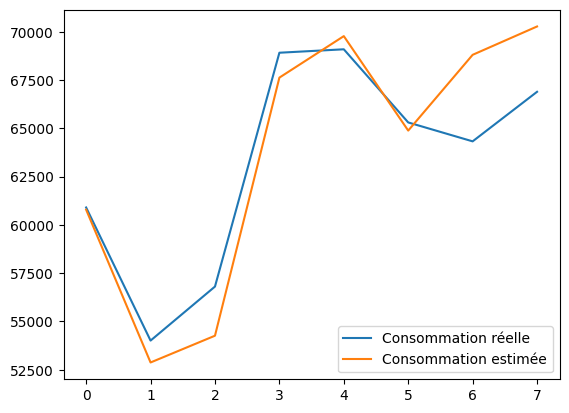

In [67]:
testDate('03/02/15', model_load)

## Traitement des données LOL

In [22]:
rapportseCo2 = pd.DataFrame()
for i in [15,16,17,18,19]:
    rapportseCo2 = pd.concat([rapportseCo2, pd.read_csv(f'./RTE/co2_20{i}.csv', sep=';', header=0, encoding='latin-1')])

rapportseCo2.to_csv('./RTE/co2.csv', sep=';', index=False)
rapportseCo2.head(3)

,Périmètre,Nature,Date,Heures,Consommation,Prévision J-1,Prévision J,Fioul,Charbon,Gaz,...,Hydraulique - Fil de l?eau + éclusée,Hydraulique - Lacs,Hydraulique - STEP turbinage,Bioénergies - Déchets,Bioénergies - Biomasse,Bioénergies - Biogaz,Stockage batterie,Déstockage batterie,Eolien terrestre,Eolien offshore
0,France,Données définitives,01/01/2015,00:00,74494.0,72900,73700,269.0,2487.0,3476.0,...,4810.0,3093.0,1418.0,560.0,181.0,197.0,NaN,NaN,NaN,NaN
1,France,Données définitives,01/01/2015,00:15,NaN,72250,73050,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,France,Données définitives,01/01/2015,00:30,73481.0,71600,72400,319.0,2087.0,2691.0,...,4616.0,3561.0,1487.0,507.0,180.0,210.0,NaN,NaN,NaN,NaN


In [31]:
temperatures.head(3)
temperatures2 = temperatures.copy()
temperatures2['date'] = temperatures2['date'].map(lambda x: x.strftime('%d/%m/%Y'))
temperatures2['heure'] = temperatures2['heure'].map(lambda x: pd.to_datetime(x, format='%H')).map(lambda x: x.strftime('%H:%M'))
temperatures2.head()

,date,heure,t
0,01/01/2015,00:00,-0.483333
1,01/01/2015,03:00,-1.133333
2,01/01/2015,06:00,-1.378571
3,01/01/2015,09:00,0.380952
4,01/01/2015,12:00,4.666667


In [38]:
#Ajouter la température
data_total = pd.merge(rapportseCo2, temperatures2, left_on=['Date', 'Heures'], right_on=['date', 'heure'], how='left')
#Drop date and hour
data_total.drop(['date', 'heure'], axis=1, inplace=True)
data_total.to_csv('./RTE/co2_with_temp.csv', sep=';', index=False)

## Pertinance des variables

In [121]:
#Pour chaque colonne, on permutte aléatoirement ses éléments
x_test_copy = np.copy(x_test)
col_score = []
for i in range(x_test_copy.shape[1]):
    x_test_copy[:,i] = np.random.permutation(x_test_copy[:,i])
    col_score.append(1/score_perceptron(x_test_copy, y_test, best_model))
    x_test_copy = np.copy(x_test)

In [122]:
col_score

[2.0206256797147484,
 1.060257610559925,
 2.6847127139778526,
 1.234628527434042,
 1.0681851018544768,
 1.8533514970969245]

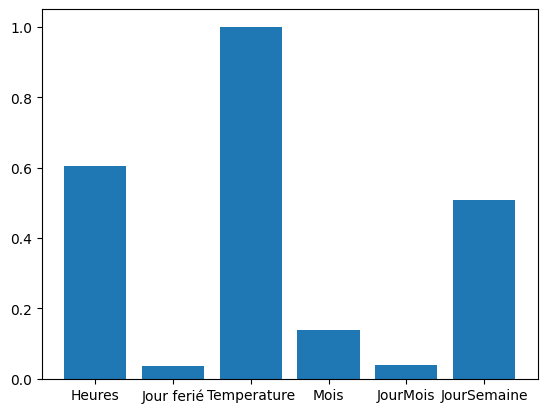

Plus la barre est haute, plus la variable est pertinente


In [123]:
colunms = ['Heures', 'Jour ferié', 'Temperature', 'Mois', 'JourMois', 'JourSemaine']
#Normalisation les valeurs entre 0 et 1
col_score_norm = np.array(col_score)
col_score_norm = (col_score_norm - 1) / (np.max(col_score_norm) - 1)
plt.bar(colunms, col_score_norm)
plt.show()
print("Plus la barre est haute, plus la variable est pertinente")